# Dynamic Sparse Distributed Memory



This notebook implements the DSDM model presented in [Online Task-free Continual Learning with Dynamic Sparse Distributed Memory](https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136850721.pdf).

In [3]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy
import numpy as np
import random
from tqdm import tqdm

from sklearn.neighbors import LocalOutlierFactor

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
from torchvision import datasets, transforms

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_name = "vits8"
#img_size = 224

In [5]:
def fix_seed():
    seed = 42
    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    numpy.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def load_preencoded_data(model_name, dataset_name,img_size,bs=64,shuffle=False,file_path=None):
    if file_path!= None:
      loaded = torch.load(file_path)
    else:
      loaded = torch.load('./data/'+dataset_name+'_'+model_name+'_'+str(img_size)+'.pt')

    trainset = torch.utils.data.TensorDataset(loaded['traindata'], loaded['trainlabel'])
    testset = torch.utils.data.TensorDataset(loaded['testdata'], loaded['label_test'])
    trainloader = torch.utils.data.DataLoader(trainset,
                                              batch_size=bs,
                                              shuffle=shuffle,
                                              num_workers=0)
    testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=bs,
                                             shuffle=shuffle,
                                             num_workers=0)
    return trainset, testset, trainloader, testloader


class SubDataset(Dataset):
    '''To sub-sample a dataset, taking only those samples with label in [sub_labels].
    After this selection of samples has been made, it is possible to transform the target-labels,
    which can be useful when doing continual learning with fixed number of output units.'''

    def __init__(self, original_dataset, sub_labels, target_transform=None, transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.sub_indeces = []
        for index in range(len(self.dataset)):
            if hasattr(original_dataset, "targets"):
                if self.dataset.target_transform is None:
                    label = self.dataset.targets[index]
                else:
                    label = self.dataset.target_transform(self.dataset.targets[index])
            else:
                label = self.dataset[index][1]
            if label in sub_labels:
                self.sub_indeces.append(index)
        self.target_transform = target_transform
        self.transform=transform

    def __len__(self):
        return len(self.sub_indeces)

    def __getitem__(self, index):
        sample = self.dataset[self.sub_indeces[index]]
        if self.transform:
            sample=self.transform(sample)
        if self.target_transform:
            target = self.target_transform(sample[1])
            sample = (sample[0], target)
        return sample
    

def compute_distances_gpu(X,Y):
    return torch.sqrt(-2 * torch.mm(X,Y.T) +
                    torch.sum(torch.pow(Y, 2),dim=1) +
                    torch.sum(torch.pow(X, 2),dim=1).view(-1,1))

In [6]:
# Class that implements a self-organizing neural network which models a DSDM.
class SONN(nn.Module):
    def __init__(self, Time_period, n_mini_batch, n_class=10, n_feat=384):
        super(SONN, self).__init__()
        self.n_feat = n_feat
        self.n_class=n_class
        self.Time_period = Time_period 
        self.ema = 2/(Time_period + 1)
        self.n_mini_batch = n_mini_batch
        self.count = 0
        self.T = 1
        self.Address = torch.zeros(1, n_feat).to(device)
        self.M = torch.zeros(1, self.n_class)
        self.p_norm = "fro"
        self.Error = torch.zeros(len(self.Address)).to(device)
        self.global_error = 0
        self.Time_period_Temperature = self.ema
        self.ema_Temperature = (2 / (self.Time_period_Temperature + 1))
        self.memory_global_error = torch.zeros(1)
        self.memory_min_distance = torch.zeros(1)
        self.memory_count_address = torch.zeros(1)
        self.dataset_name = "MNIST"
        
        self.acc_after_each_task = []
        self.acc_aft_all_task = []
        self.stock_feat = torch.tensor([]).to(device)
        self.forgetting = []
        self.N_prune = 5000 # Pruning threshold
        self.prune_mode = "balance"
        self.n_neighbors = 20
        self.contamination = "auto"
        self.pruning = False 
        self.cum_acc_activ = False
        self.batch_test = True
        
        self.reset()
        
    def apply_param(self, T, pruning, N_prune, n_neighbors, Time_period_Temperature):
        self.T = T
        self.pruning = True
        self.N_prune = N_prune
        self.n_neighbors = n_neighbors
        self.Time_period_Temperature = Time_period_Temperature
        
    def reset(self):
        self.ema = 2 / (self.Time_period + 1)
        self.ema_Temperature = (2 / (self.Time_period_Temperature + 1))
        self.count = 0
        self.Address = torch.zeros(1, self.n_feat).to(device)
        self.M = torch.zeros(1, self.n_class).to(device)
        self.Error = torch.zeros(len(self.Address)).to(device)
        self.global_error = 0
        self.memory_global_error = torch.zeros(1)
        self.memory_min_distance = torch.zeros(1)
        self.memory_count_address = torch.zeros(1)
        
    def forward(self, inputs):
      # No gradient will be computed.
        with torch.no_grad():
            out = inputs
            pred = torch.tensor([]).to(device)
            # Get prediction.
            if self.batch_test:
                # Compute distance from inputs to adress space.
                distance = compute_distances_gpu(inputs, self.Address)
                # Calculate neuron weight based on distance.
                soft_norm = F.softmin(distance/self.T, dim=-1)
                # Pool weighted (come from the dtistance) content to get prediction.
                pred = torch.matmul(soft_norm, self.M)
            else:
                for idx_x in range(len(out)):
                    x = out[idx_x]
                    distance = x - self.Address
                    norm = torch.norm(distance, p=self.p_norm, dim=-1)
                    # softmin vs argmin
                    soft_norm = F.softmin(norm/self.T, dim=-1)
                    soft_pred = torch.matmul(soft_norm, self.M.to(device)).view(-1)
                    pred = torch.cat((pred, soft_pred.view(1,-1)), 0)
        return pred   
    
    def prune(self):
        N_pruning = self.N_prune
        n_class = self.M.size(1)
        if len(self.Address) > N_pruning:
            clf = LocalOutlierFactor(n_neighbors=min(len(self.Address), self.n_neighbors), contamination=self.contamination)
            A = self.Address
            M = self.M
            y_pred = clf.fit_predict(A.cpu())
            X_scores = clf.negative_outlier_factor_
            x_scor = torch.tensor(X_scores)
            # "Naive" pruning mode.
            if self.prune_mode == "naive":
                if len(A) > N_pruning:
                    prun_N_addr = len(A) - N_pruning # No. of addresses that must be pruned out.
                    val, ind = torch.topk(x_scor, prun_N_addr) 
                    idx_remove = [True] * len(A)
                    for i in ind:
                        idx_remove[i] = False
                    self.M = self.M[idx_remove] # Delete content from address.
                    self.Address = self.Address[idx_remove] # Delete address.
            # "Balance" pruning mode.
            if self.prune_mode == "balance":
                prun_N_addr = len(A) - N_pruning # No. of addresses that must be pruned out.
                mean_addr = N_pruning // n_class
                val, ind = torch.sort(x_scor, descending=True)

                count = prun_N_addr
                idx_remove = [True] * len(A)
                idx = 0
                arg_m = torch.argmax(M, axis=1)
                N_remaining = torch.bincount(arg_m)
                while count != 0:
                    idx +=1
                    indice = ind[idx]
                    if N_remaining[arg_m[indice]] > (N_pruning // n_class):
                        N_remaining[arg_m[indice]] -= 1
                        idx_remove[ind[idx]] = False
                        count-=1
                self.M = self.M[idx_remove]
                self.Address = self.Address[idx_remove]
        
    def test(self, testloader):
      """ Test batch-wise. """
      total = 0
      correct = 0

      for batch_idx, (inputs, targets) in enumerate(testloader):
          targets = targets.type(torch.LongTensor).to(device)
          inputs = inputs.to(device)
          # Pass inputs through NN to get prediction.
          outputs = self.forward(inputs)
          _, predicted = torch.max(outputs, 1)
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total * 100
      print("test accuracy {:.3f} %,  {:.3f} / {:.3f} ".format(accuracy, correct, total))
      return accuracy
    
    def test_idx(self, test_dataset_10_way_split, idx_test):
        with torch.no_grad():
            total = 0
            correct = 0

            for idx in idx_test:
                curr_correct = 0
                curr_total = 0
                for batch_idx, (inputs, targets) in enumerate(test_dataset_10_way_split[idx]):
                    inputs = inputs.to(device)
                    targets = targets.type(torch.LongTensor).to(device)
                    # Pass inputs through NN to get prediction.
                    outputs = self.forward(inputs)
                    _, predicted = torch.max(outputs,1)
                    total += targets.size(0)
                    corr = (predicted == targets).sum().item()
                    curr_correct +=corr
                    correct += corr
                    curr_total += targets.size(0)
            accuracy = correct / total * 100
        return accuracy, curr_correct / curr_total * 100
    
    def train__test_n_way_split(self, train_dataset_10_way_split, test_dataset_10_way_split, coef_global_error=1, ema_global_error=None, plot=True, save_feat=False): # n equal len train_dataset_10_way_split
        flag = False
        acc_test = torch.zeros(len(train_dataset_10_way_split)) # Tensor to hold the accuracies for each train split.
        acc_test_after_each_task_softmin = torch.zeros(len(train_dataset_10_way_split))
        self.memory_min_distance = torch.zeros(1)
        idx_seen = []
        self.cum_acc = []

        with torch.no_grad():
            for idx_loader in range(len(train_dataset_10_way_split)):
              # Mark task as already encountered.
                idx_seen.append(idx_loader)

                # Task train loop: Iterate over the batches of each task.
                for batch_idx, (inputs, targets) in enumerate(train_dataset_10_way_split[idx_loader]):
                    inputs = inputs.to(device)
                    targets = targets.type(torch.LongTensor).to(device)
                    if batch_idx == self.n_mini_batch:
                        break
                    if save_feat:
                        self.stock_feat = torch.cat((self.stock_feat, inputs))
                    # Sample loop: Iterate over all samples in the current batch.
                    for idx_x in range(len(inputs)):
                        out = inputs
                        x = out[idx_x]
                        self.count += 1
                        # List of bit-wise difference vectors: 0 - elements are the same & {1, -1} - elements are different. 
                        distance = x - self.Address
                        # List of Hamming distances
                        norm = torch.norm(distance, p=self.p_norm, dim=-1)
                        # Will be later fed as input to an sofmin layer.
                        soft_norm = norm
                        # Get minimum Hamming distance and the corresponding neuron index.  
                        min_value, idx_min = torch.min(norm, 0)
                        # Adjust parameter.
                        self.global_error += self.ema_Temperature * (min_value - self.global_error)

                        # Check if the distance is bigger than the adaptive threshold.
                        if abs(norm[idx_min]) >= self.global_error * coef_global_error:
                            # Create a new node with the adress currently being processed.
                            self.Address = torch.cat((self.Address, x.view(1, -1)))
                            # Create classification content encoding.
                            targets_one_hot = F.one_hot(targets[idx_x], num_classes=self.n_class).float()
                            # Create a nre entry into the memory.
                            self.M = torch.cat((self.M, targets_one_hot.view(1,-1)))
                        else:
                            delta_address = distance
                            # List of Hamming distances mapped to probabilities.
                            soft_norm = F.softmin(norm/self.T, dim=-1)
                            # Modify all existing addresses. The modification is made according to the weight. 
                            self.Address = self.Address + self.ema * torch.mul(soft_norm.view(-1, 1), delta_address)
                            # Get content encoding.
                            targets_one_hot = F.one_hot(targets[idx_x], num_classes=self.n_class).float()
                            # Modify content accordingly.
                            self.M += self.ema * torch.mul(soft_norm.view(-1, 1), (targets_one_hot - self.M))
                # Prune memory.
                if self.pruning:
                    self.prune()
                # 
                if self.cum_acc_activ:
                    acc, last_acc = self.test_idx(test_dataset_10_way_split, idx_seen)
                    self.cum_acc.append(acc)
                    acc_test_after_each_task_softmin[idx_loader] = last_acc
            # Update after task accuracy.
            self.acc_after_each_task = acc_test_after_each_task_softmin
            acc_test_after_each_task_softmin = acc_test_after_each_task_softmin
            
            acc_test_after_all_task_softmin = torch.zeros(len(train_dataset_10_way_split))
            acc_test = torch.zeros(len(train_dataset_10_way_split))

            # Test after all tasks are learned.
            for idx_loader in range(len(test_dataset_10_way_split)):
                count_input = 0
                correct = 0
                correct_softmin = 0

                if self.batch_test:
                    acc, last_acc = self.test_idx(test_dataset_10_way_split, [idx_loader])
                    acc_test[idx_loader] = 0 
                    acc_test_after_all_task_softmin[idx_loader] = last_acc
                else:
                    for batch_idx, (inputs, targets) in enumerate(test_dataset_10_way_split[idx_loader]):
                        out = inputs.to(device)
                        targets = targets.type(torch.LongTensor)
                        for i in range(len(out)):
                            count_input += 1
                            x = out[i]
                            distance = x-self.Address
                            norm = torch.norm(distance, p=self.p_norm, dim=-1)
                            # softmin
                            soft_norm = F.softmin(norm/self.T, dim=-1)
                            soft_pred = torch.matmul(soft_norm, self.M.to(device)).view(-1)
                            arg_soft_pred = torch.argmax(soft_pred)
                            # argmin
                            idx = torch.argmin(norm)
                            pred = torch.argmax(self.M[idx])
                            if pred == targets[i]:
                                correct += 1
                            if arg_soft_pred == targets[i]:
                                correct_softmin += 1
                    acc_test[idx_loader] = correct / count_input*100
                    acc_test_after_all_task_softmin[idx_loader] = correct_softmin / count_input * 100

                self.acc_aft_all_task = acc_test_after_all_task_softmin
            if plot:
                plt.figure(figsize=(15,10))
                plt.plot(acc_test)
                plt.plot(acc_test_just_after_learn_1_task)
                plt.plot(acc_test_after_all_task_softmin)
                plt.legend(["after learn all task","after learn each task","after learn all task with softmin"])
                plt.title("accuracy on all task = {:.2f} %".format(acc_test.mean().item())+"same accuracy with softmin (with T= {:.2f}) =".format(self.T)+"{:.3f}".format(acc_test_after_all_task_softmin.mean().item())+" on 10 way split cifar 10,\n Time_period = "+ str(Time_period)+ " number of data per class = "+str(self.n_mini_batch*bs)+" address use "+str(self.M.size(0)))  
                plt.ylabel("test accuracy %")
                plt.xlabel("task 0 to task 9")
                for i in range(0,self.n_class):
                    plt.vlines(i,min(acc_test),100,colors='k', linestyles='dotted', label='end task 0')
                plt.show()
                plt.figure(figsize=(15,10))
                n_taskss=(np.linspace(0,len(test_dataset_10_way_split),len(self.memory_global_error)))
                plt.plot(n_taskss,self.memory_global_error)
                n_taskss=(np.linspace(0,len(test_dataset_10_way_split),len(self.memory_min_distance)))
                plt.plot(n_taskss,self.memory_min_distance, alpha=0.3)
                n_taskss=(np.linspace(0,len(test_dataset_10_way_split),len(self.memory_count_address)))
                plt.plot(n_taskss,self.memory_count_address/max(self.memory_count_address)*100)
                for i in range(1,len(test_dataset_10_way_split)+1):
                    plt.vlines(i,0,70,colors='k', linestyles='dotted', label='end task 0')
                plt.show()
            return acc_test_after_each_task_softmin, acc_test_after_all_task_softmin
        
    def grid_search_spread_factor(self, Time_period, n_mini_batch, train_dataset_10_way_split, test_dataset_10_way_split, N_try=5, ema_global_error="same", coef_global_error=1, plot=True, random_ordering=True):
        """ """
        flag = False
        acc_test = torch.zeros(N_try, len(train_dataset_10_way_split))
        accuracy_std_test = torch.zeros(len(train_dataset_10_way_split))
        accuracy_mean_test = torch.zeros(len(train_dataset_10_way_split))
        
        cum_acc = torch.zeros(N_try, len(train_dataset_10_way_split))
        
        acc_test_softmin = torch.zeros(N_try,len(train_dataset_10_way_split))
        accuracy_mean_test_softmin = torch.zeros(len(train_dataset_10_way_split))
        accuracy_std_test_softmin = torch.zeros(len(train_dataset_10_way_split))
        N_address_use = torch.zeros(N_try)
        self.forgetting = []
        
        self.n_mini_batch = n_mini_batch
        self.Time_period = Time_period 
        self.ema = 2 / (Time_period + 1)

        for idx_try in tqdm(range(N_try)):
            self.reset()
            Acc_test, Acc_test_softmin = self.train__test_n_way_split(train_dataset_10_way_split,
                                                                      test_dataset_10_way_split,
                                                                      ema_global_error=ema_global_error,
                                                                      plot=False,
                                                                      coef_global_error=coef_global_error)
            if self.cum_acc_activ:
                cum_acc[idx_try] = torch.tensor(self.cum_acc)
            self.forgetting.append((self.acc_after_each_task * 100 - self.acc_aft_all_task).mean())
            acc_test[idx_try] = Acc_test
            acc_test_softmin[idx_try] = Acc_test_softmin
            N_address_use[idx_try] = self.M.size(0)
            # Random ordering for new training.
            if random_ordering:
                dataset_shuffle = list(zip(train_dataset_10_way_split, test_dataset_10_way_split))
                random.shuffle(dataset_shuffle)
                train_dataset_10_way_split, test_dataset_10_way_split = zip(*dataset_shuffle)

        accuracy_mean_test = acc_test.mean(0)
        accuracy_std_test = acc_test.std(0)
        accuracy_mean_test_softmin = acc_test_softmin.mean(0)
        acc_soft_mean = acc_test_softmin.mean(1)
        accuracy_std_test_softmin = acc_test_softmin.std(0)

        print("forgetting softmin inference = {:.1f} % ± {:.1f}".format(np.mean(self.forgetting), np.std(self.forgetting)))

        if plot:
            plt.errorbar(np.linspace(1,len(accuracy_mean_test_softmin),len(accuracy_mean_test_softmin)),accuracy_mean_test_softmin,accuracy_std_test_softmin,linestyle='None', fmt='o',capsize = 5)
            print(str(len(train_dataset_10_way_split))+"-way split, MNIST test accuracy on all task = {:.1f} % ± {:.1f}, mean Address use =  {:.1f} ".format(acc_soft_mean.mean().item(), acc_soft_mean.std().item(),N_address_use.mean()))#
            print(["accuracy softmin T_softmin = {:.1f} ".format(self.T)])
            plt.xlabel("task 1 to task "+str(len(train_dataset_10_way_split)))
            plt.ylabel("Test Accuracy")
            plt.ylim(bottom=40)
            plt.savefig("DSDM MNIST.pdf")
            plt.show()
          
        return acc_soft_mean, N_address_use.mean(), acc_test, cum_acc


In [7]:
img_size = 224
model_name = "resnet18"
dataset_name = "Core50"

In [8]:
!gdown --id 1Yo7VJ93VGWQo070QHKB_6mG76iNDrVvT

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Yo7VJ93VGWQo070QHKB_6mG76iNDrVvT
To: /content/Core50_resnet18_224.pt
100% 338M/338M [00:02<00:00, 133MB/s]


In [9]:
file_path= "/content/Core50_resnet18_224.pt" 
bs = 50 # 50 samples per batch

# Load data.
trainset, testset, trainloader, testloader = load_preencoded_data(model_name, dataset_name, img_size, file_path=file_path)

# Split train set into train set and validation set
train_set, val_set = torch.utils.data.random_split(trainset, [25000, len(trainset)-25000])


train_cifar100_100_way_split = []
val_cifar100_100_way_split = []
test_cifar100_100_way_split = []
i = 0 # Used to construct labels

train_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(train_set, [i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8, i+9]),
                                                                batch_size=bs,
                                                                shuffle=True,
                                                                num_workers=0))
val_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(val_set,[i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8, i+9]),
                                                              batch_size=bs,
                                                              shuffle=False,
                                                              num_workers=0))
test_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(testset,[i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8, i+9]),
                                                               batch_size=bs,
                                                               shuffle=False,
                                                               num_workers=0))
for i in range(10, 50, 5):
    train_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(train_set, [i, i+1, i+2, i+3, i+4]),
                                                                    batch_size=bs,
                                                                    shuffle=True,
                                                                    num_workers=0))
    val_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(val_set, [i, i+1, i+2, i+3, i+4]),
                                                                  batch_size=bs,
                                                                  shuffle=False,
                                                                  num_workers=0))
    test_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(testset, [i, i+1, i+2, i+3, i+4]),
                                                                   batch_size=bs,
                                                                   shuffle=False,
                                                                   num_workers=0))

In [14]:
accuracy_c100_100w

NameError: ignored

100%|██████████| 5/5 [01:40<00:00, 20.11s/it]


forgetting softmin inference = 4063.1 % ± 413.6
9-way split, MNIST test accuracy on all task = 41.9 % ± 1.6, mean Address use =  1000.0 
['accuracy softmin T_softmin = 2.3 ']


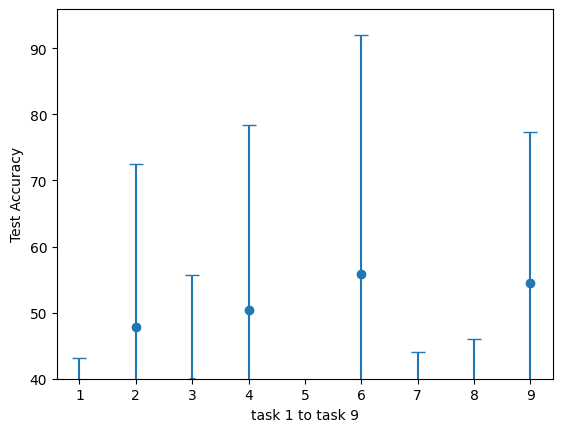

tensor(45.4808)
tensor(41.9142) 1000


100%|██████████| 5/5 [01:54<00:00, 22.91s/it]


forgetting softmin inference = 5078.3 % ± 301.6
9-way split, MNIST test accuracy on all task = 49.5 % ± 1.6, mean Address use =  2000.0 
['accuracy softmin T_softmin = 2.3 ']


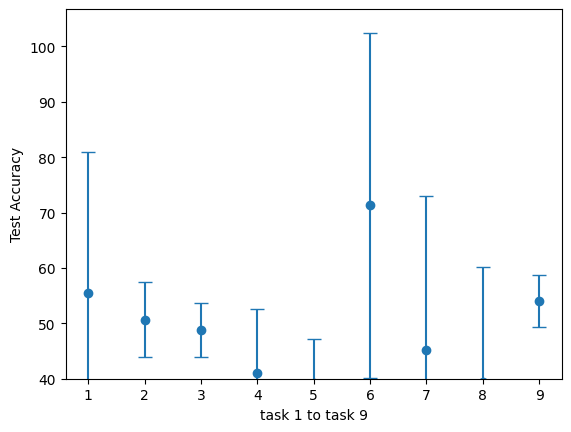

tensor(54.5155)
tensor(49.4949) 2000


100%|██████████| 5/5 [02:56<00:00, 35.35s/it]


forgetting softmin inference = 6382.1 % ± 184.1
9-way split, MNIST test accuracy on all task = 56.0 % ± 0.3, mean Address use =  5000.0 
['accuracy softmin T_softmin = 2.3 ']


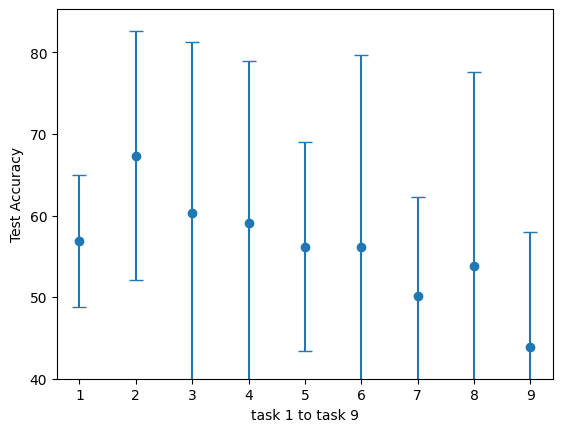

tensor(66.7153)
tensor(55.9732) 5000


100%|██████████| 5/5 [03:10<00:00, 38.06s/it]


forgetting softmin inference = 7335.9 % ± 170.6
9-way split, MNIST test accuracy on all task = 67.5 % ± 0.4, mean Address use =  10000.0 
['accuracy softmin T_softmin = 2.3 ']


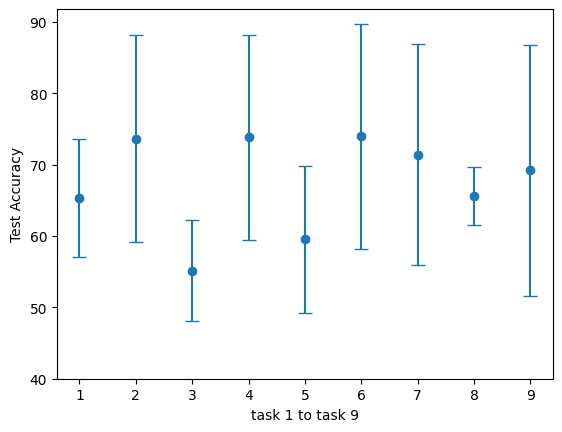

tensor(72.0152)
tensor(67.5265) 10000


In [15]:
nprune = [1000, 2000, 5000, 10000]
for i in nprune:
    N_try = 5 
    n_mini_batch = 55
    alpha = 1
    Time_period = 500
    Time_period_temperature = 150

    # Instantiate DSDM instance.
    sonn = SONN(Time_period, n_mini_batch, 50, n_feat=512)
    sonn.n_neighbors = 1000
    sonn.contamination = "auto"
    sonn.p_norm = "fro"
    sonn.T = 2.3
    sonn.pruning = True
    sonn.N_prune = i
    sonn.cum_acc_activ = True
    sonn.Time_period_Temperature = Time_period_temperature

    # Train and test DSDM.
    accuracy_c100_100w, N_address_use_c100_100w, acc_test_softmin, cum_sum = sonn.grid_search_spread_factor(Time_period,
                                                                                                            n_mini_batch,
                                                                                                            train_cifar100_100_way_split,
                                                                                                            test_cifar100_100_way_split,
                                                                                                            N_try,
                                                                                                            ema_global_error="diff",
                                                                                                            coef_global_error=alpha)
    metric = accuracy_c100_100w.mean()
    print(cum_sum.mean())
    print(metric, len(sonn.Address))